### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [7]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import time_series_multiperiodic

In [32]:
#On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = time_series_multiperiodic("multi_periodic")

#On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

T_MOY_ANNUELLE = 12 #°C, représente l'offset commun de nos signaux de température

T_AMP_ANNUELLE = 6 #°C, représente l'amplitude de variation de température annuelle

T_AMP_JOURNALIERE = 1 #°C, représente l'amplitude de variation de température journalière

P_an = 12 #Période annuelle en mois

P_jour = 24 #Période journalière, en heures

t_debut = (2024, 4, 15, 8, 0, 0) #On commence le 15 avril 2024 à 8h00
t_fin = (2024, 8, 15, 8, 0, 0) #On finit le 15 avril 2025 à 8h00, on regarde ce qu'il se passe sur un an. 
dt = 15*NSECINMIN #On regarde à l'échelle de l'heure, pour pouvoir compiler plus facilement

In [23]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Conditions limites"""
# Température de la rivière
zeroT = 0
zeroT += ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 14 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.5 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4

"""Bruit de mesure"""
sigma_meas_P = 0.001
sigma_meas_T = 0.1

print("dt={0:.1f}s".format(dt))

dt=900.0s


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 8, 15, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.5]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.5, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



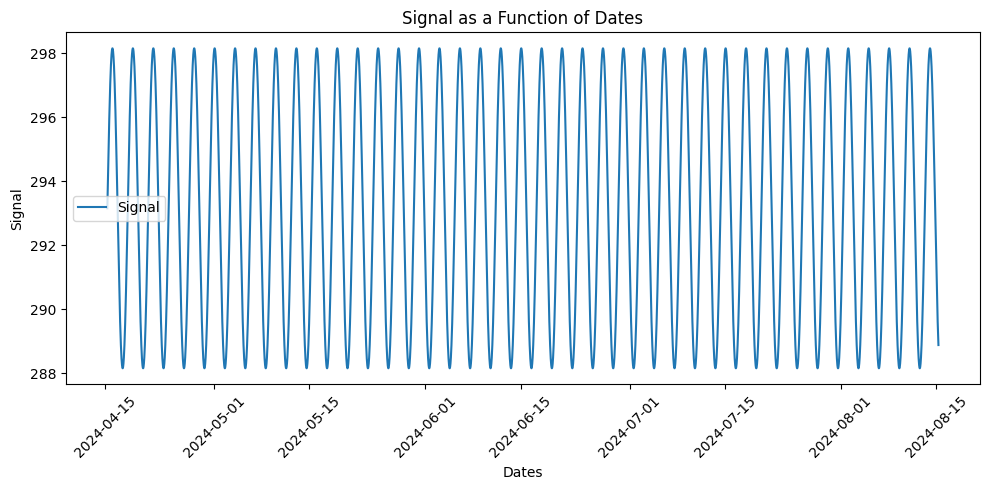

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  ... 288.53198895 288.48728208
 288.44408048]
Temperature of Sensor 1 : [290.15       290.20453721 290.25904847 ... 288.07132597 288.04152139
 288.01272032]
Temperature of Sensor 2 : [288.65       288.67726861 288.70452423 ... 287.61066298 287.59576069
 287.58136016]
Temperature of Sensor 3 : [287.15 287.15 287.15 ... 287.15 287.15 287.15]
dH : [(datetime.datetime(2024, 4, 15, 8, 0), (0.499104616705186, 292.9481405388721)), (datetime.datetime(2024, 4, 15, 8, 15), (0.499821036148707, 293.24904299725324)), (datetime.datetime(2024, 4, 15, 8, 30), (0.49911954156042126, 293.5239680209094)), (datetime.datetime(2024, 4, 15, 8, 45), (0.4998903663251208, 293.5853341047477)), (datetime.datetime(2024, 4, 15, 9, 0), (0.49960992501873835, 293.4629463588894)), (datetime.datetime(

In [24]:
"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)

# print("Checking params synthetic_MOLONARI")
# print("param_time_dates:", emu_observ_test_user1._param_dates)
# print("param_dH_signal:", emu_observ_test_user1._param_dH)
# print("param_T_riv_signal:", emu_observ_test_user1._param_T_riv)
# print("param_T_aq_signal:", emu_observ_test_user1._param_T_aq)
# print("sigma_meas_P:", emu_observ_test_user1._sigma_P)
# print("sigma_meas_T:", emu_observ_test_user1._sigma_T)


print(f"dH : {emu_observ_test_user1._molonariP_data}")
print(f"Tshaft : {emu_observ_test_user1._T_Shaft_measures}")

In [26]:
#On print l'attribut date de l'objet créé pour voir si la forme convient 

print(f"Dates : {emu_observ_test_user1._dates}")

Dates : [datetime.datetime(2024, 4, 15, 8, 0)
 datetime.datetime(2024, 4, 15, 8, 15)
 datetime.datetime(2024, 4, 15, 8, 30) ...
 datetime.datetime(2024, 8, 15, 7, 15)
 datetime.datetime(2024, 8, 15, 7, 30)
 datetime.datetime(2024, 8, 15, 7, 45)]


Creating a multi-periodic signal, with the following period: [[12, 'm'], [24, 'h']] and the following amplitude: [6, 1]
periods : [31104000, [24, 'h']]
periods : [31104000, 86400]


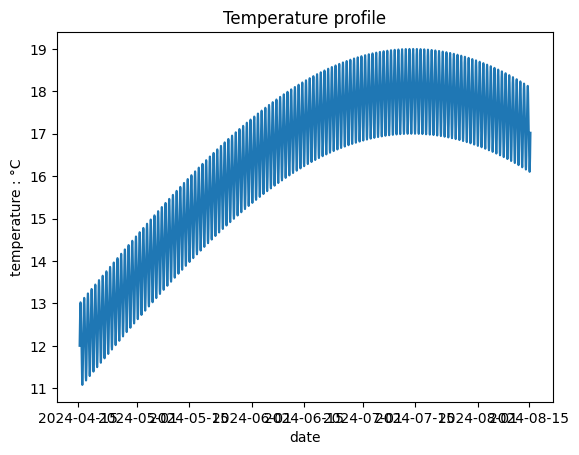

In [33]:
#On utilise le jeu de date précédent pour créer un signal de température multipériodique 

T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)

T_riv.plot() #On affiche le signal de température créé

In [ ]:
#On 